In [1]:
from loadingCGAN.novgan import Novgan
from load_data.load_data import load_data
from utils.config_novgan import nrows, place, activation, latent_dim, leaky_relu, alpha, offset
from utils.config_novgan import balanced_train_size, shuffle, cv_size, smooth_one, smooth_zero, batch_size
from loadingCGAN.utils_cgan import creating_dico_index

Using TensorFlow backend.


In [2]:
# DATA
x_train, x_train_cv, y_train, y_train_cv, x_balanced_train, y_balanced_train, x_test, y_test, colnames = load_data(place=place,
                                                                                                                   verbose=False,
                                                                                                                   nrows=nrows,
                                                                                                                   cv_size=cv_size,
                                                                                                                   log_transform=True,
                                                                                                                   shuffle=shuffle, return_colnames=True)
if balanced_train_size is not None:
    x_balanced_train, y_balanced_train = x_balanced_train[:balanced_train_size], y_balanced_train[:balanced_train_size]

data_dim = x_train.shape[1]

print(data_dim)

/home/peseux/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/peseux/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


122


In [3]:
dico_index = creating_dico_index(colnames=colnames)

print(dico_index)

{'num_access_files': 11, 'num_shells': 10, 'src_bytes': 1, 'dst_bytes': 2, 'root_shell': 34, 'num_root': 8, 'su_attempted': 37, 'num_file_creations': 9}


# NovGan 

In [4]:
novgan = Novgan(data_dim=data_dim, activation=activation, verbose=True,
                latent_dim=latent_dim,
                leaky_relu=leaky_relu, offset=0, alpha=0, dropout=.2,
                dico_index=dico_index,
                noise="normal",
                smooth_one=smooth_one, smooth_zero=smooth_zero, batch_size=batch_size)

Instructions for updating:
Colocations handled automatically by placer.
CHOSEN OPTIMIZER IS ADAM

 
 Generator Architecture 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                3264      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 122)               15738     
Total params: 27,322
Trainable params: 27,322
Non-trainable params: 0
_________________________________________________________________
Instructions 

In [5]:
import numpy as np
number = 10
noise = np.random.normal(0, 1, (number, latent_dim))

In [6]:
novgan.gan.evaluate(noise, np.ones(10))

10/10 [==============================] - 0s 19ms/step


0.0

In [7]:
novgan.discriminator.evaluate(x_test[:1], np.zeros(1))

1/1 [==============================] - 0s 35ms/step


1.227900505065918

In [8]:
novgan.generate(1)

array([[-0.17393297, -0.05017926,  0.63855124, -0.68167746,  0.79730505,
         0.6698461 , -0.6795225 , -0.4336543 ,  0.19987506, -0.58326036,
        -0.03647175, -0.12835161, -0.18921055, -0.2611269 , -0.5331572 ,
        -0.03823943, -0.5390991 ,  0.17482895, -0.03421913,  0.23424318,
        -0.2516661 , -0.28031838,  0.41460148, -0.24916476, -0.23649676,
        -0.42526802, -0.6372372 , -0.57204336, -0.31591576, -0.34322208,
         0.2969796 ,  0.52028865, -0.7144775 ,  0.449537  , -0.39133796,
        -0.06690567,  0.25431183, -0.01308552, -0.6212097 , -0.5233844 ,
        -0.5258357 ,  0.4475483 , -0.08575715, -0.6184805 ,  0.7461466 ,
         0.26347914, -0.23528472,  0.18306154, -0.24346247, -0.5968913 ,
         0.13182487,  0.00543348, -0.37800494,  0.24745482, -0.43676862,
        -0.1279283 , -0.01116381, -0.44437763, -0.7079109 ,  0.02511819,
         0.81175053,  0.7839261 ,  0.16004546, -0.3935713 , -0.46733332,
         0.20589358,  0.11639372,  0.13610983,  0.1

Instructions for updating:
Use tf.cast instead.


/home/peseux/.local/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


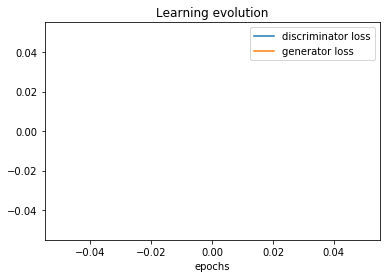

True

In [9]:
learned = novgan.train(x_train=x_train, epochs=10, print_recap=False)


novgan.plot_learning()

In [10]:
learned

([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])